In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tvb.simulator.lab import *
import mne

   INFO  Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
   INFO  NumExpr defaulting to 8 threads.


D:\Software\Anaconda3\envs\tvb-python3\lib\site-packages\tvb\datatypes\surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

WARNING  File 'hemispheres' not found in ZIP.
   INFO  Projection configured gain shape (65, 76)


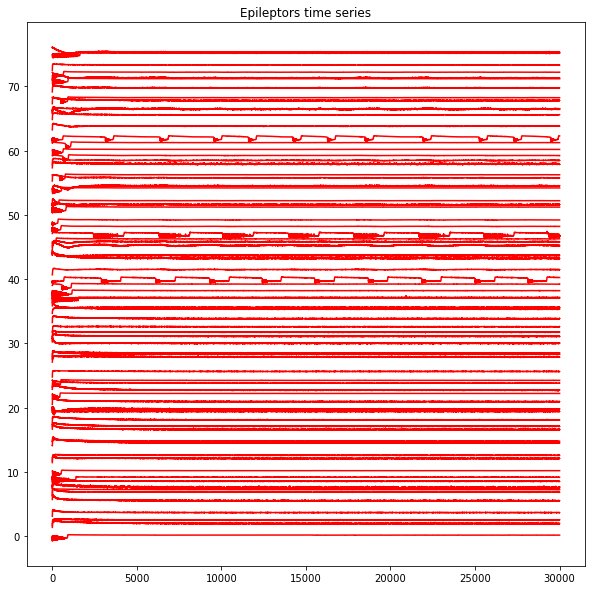

Text(0.5, 1.0, 'EEG')

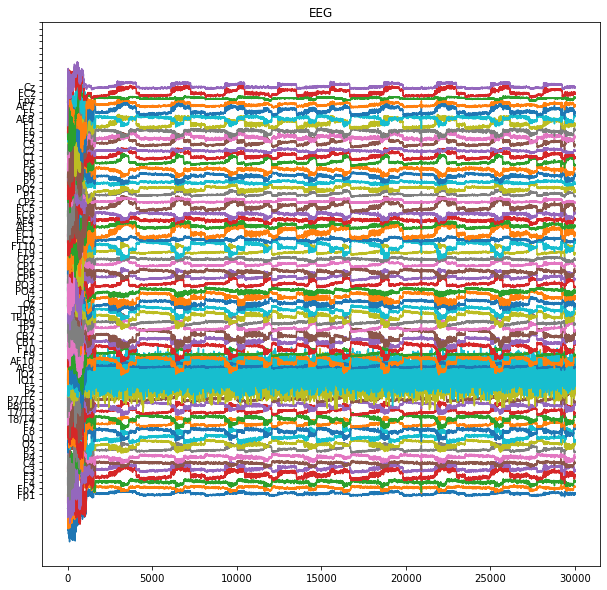

In [2]:
epileptors = models.Epileptor(Ks=np.array([-0.2]), Kf=np.array([0.1]), r=np.array([0.00015]))
epileptors.x0 = np.ones((76))*-2.4
# Setting epileptogenic regions
ezs = [62, 47, 40]
epileptors.x0[ezs] = -1.6
# epileptors.x0[[69, 72]] = -1.8

con = connectivity.Connectivity.from_file()
coupl = coupling.Difference(a=np.array([1.]))

hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

# load the default region mapping
rm = region_mapping.RegionMapping.from_file()

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)
mon_EEG = monitors.EEG.from_file()
mon_EEG.region_mapping=rm
mon_EEG.period=1.

what_to_watch = (mon_tavg, mon_EEG)

#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model=epileptors, connectivity=con,
                          coupling=coupl,
                          integrator=heunint, monitors=what_to_watch)

sim.configure()

(ttavg, tavg), (teeg, eeg) = sim.run(simulation_length=30000)

# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
eeg -= np.mean(eeg, 0)

#Plot raw time series
plt.figure(figsize=(10,10))
plt.plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
plt.title("Epileptors time series")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(teeg[:], 10*eeg[:, 0, :, 0] + np.r_[:65])
plt.yticks(np.r_[:75], mon_EEG.sensors.labels[:65])
plt.title("EEG")

In [3]:
# Create and save mne object
data = eeg[:, 0, :, 0].T
info = mne.create_info(ch_names=list(mon_EEG.sensors.labels[:65]), sfreq=1000, ch_types='eeg')
raw = mne.io.RawArray(data, info)
raw.save('eeg_sim_raw.fif', overwrite=True)

Creating RawArray with float64 data, n_channels=65, n_times=30000
    Range : 0 ... 29999 =      0.000 ...    29.999 secs
Ready.
Overwriting existing file.
Writing D:\JHU\Sri_Lab\eeg_sim_raw.fif
Closing D:\JHU\Sri_Lab\eeg_sim_raw.fif [done]


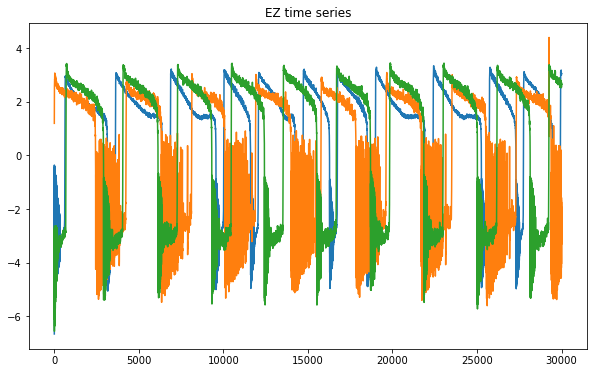

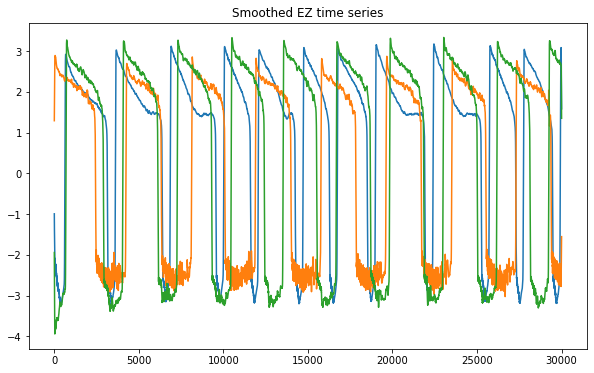

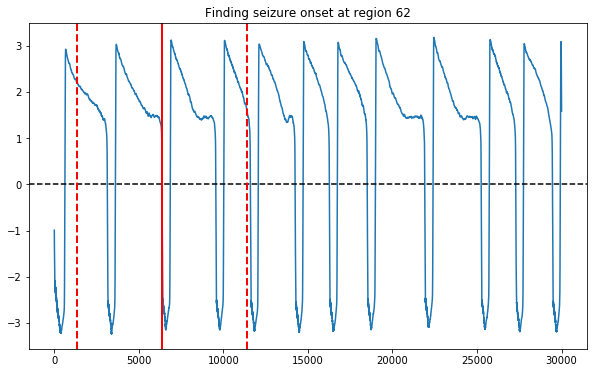

In [4]:
plt.figure(figsize=(10,6))
ez_series = tavg[:, 0, ezs, 0]
plt.plot(ttavg[:], ez_series*10)
plt.title("EZ time series")

# Smooth EZ time series
win = 50
mov_ave = np.repeat(1, win)*1/win
ez_series_smooth = np.zeros(np.shape(ez_series))
for i in range(len(ezs)):
    ez_series_smooth[:,i] = np.convolve(ez_series[:,i], mov_ave, mode='same')

# seizure onset: tavg changing from positive to negative
states = (ez_series_smooth[:,0] > 0)
states_diff = np.diff(states.astype(int))
onsets = np.argwhere(states_diff == -1).flatten()

# Find the first seizure onset, extract EEG and Epileptor time series 5s before and after onset
for onset in onsets:
    if onset > 5*1000:
        break

plt.figure(figsize=(10,6))
plt.plot(ttavg[:], ez_series_smooth*10)
plt.title("Smoothed EZ time series")

plt.figure(figsize=(10, 6))
plt.plot(ttavg[:], ez_series_smooth[:,0]*10)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(onset, color='r', linewidth=2)
plt.axvline(onset-5*1000, color='r', linewidth=2, linestyle='--')
plt.axvline(onset+5*1000, color='r', linewidth=2, linestyle='--')
plt.title(f"Finding seizure onset at region {ezs[0]}")
plt.show()

Text(0.5, 1.0, 'EEG at seizure onset')

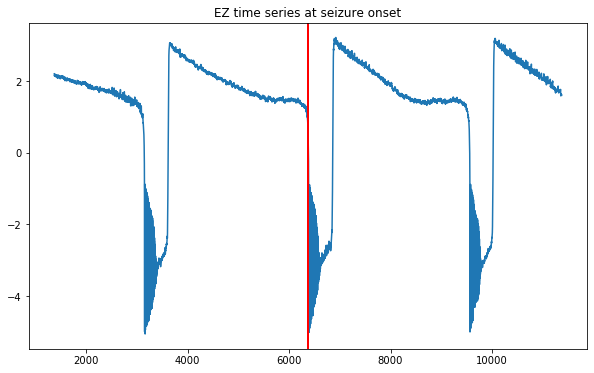

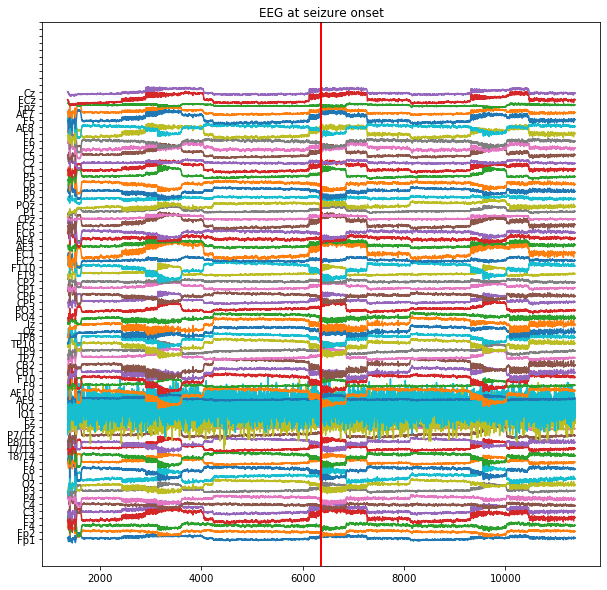

In [5]:
plt.figure(figsize=(10,6))
plt.plot(ttavg[onset-5*1000:onset+5*1000], tavg[onset-5*1000:onset+5*1000, 0, ezs[0], 0]*10)
plt.axvline(onset, color='r', linewidth=2)
plt.title("EZ time series at seizure onset")

plt.figure(figsize=(10,10))
plt.plot(teeg[onset-5*1000:onset+5*1000], 10*eeg[onset-5*1000:onset+5*1000, 0, :, 0] + np.r_[:65])
plt.axvline(onset, color='r', linewidth=2)
plt.yticks(np.r_[:75], mon_EEG.sensors.labels[:65])
plt.title("EEG at seizure onset")